In [100]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, Model
from keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates


In [101]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/shortened2.csv', index_col='time_slot', parse_dates=['time_slot'])

In [102]:
df.head()

,n_visits,n_shifts,utilization
time_slot,,,
2019-01-14,14,36,0.600023
2019-01-15,24,36,0.651213
2019-01-16,24,36,0.665499
2019-01-30,23,36,0.661332
2019-01-31,22,37,0.680456


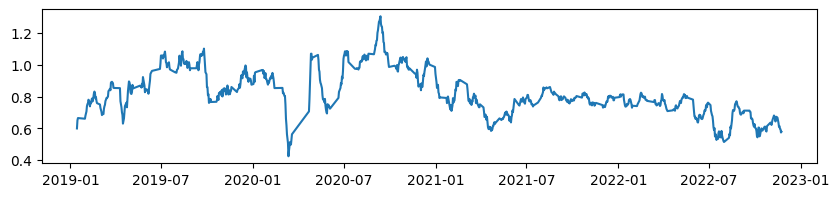

In [103]:
x = df.index
y = df['utilization']
plt.figure(figsize=(10, 2))
plt.plot(x,y)

### Transformer

In [138]:
# Data Preprocessing
data = df
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

look_back=1

# Define function to create time series dataset with additional features
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back)])
        Y.append(data[i+look_back, -1]) # Utilization is the last column
    return np.array(X), np.array(Y)

# Split the dataset
train_size = int(len(data_scaled) * 0.85)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:]
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], look_back, train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], look_back, test_X.shape[2]))

In [163]:
print('train_X: ', train_X.shape)
print('test_X: ', test_X.shape)
print('-------')
print('train_Y: ', train_Y.shape)
print('test_Y: ', test_Y.shape)

train_X:  (773, 10, 3)
test_X:  (129, 10, 3)
-------
train_Y:  (773,)
test_Y:  (129,)


In [146]:
# Define the Transformer Architecture
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    attn_output = MultiHeadAttention(num_heads=8, key_dim=input_shape[1])(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    attn_output2 = MultiHeadAttention(num_heads=16, key_dim=input_shape[1])(out1, out1)
    attn_output2 = Dropout(0.4)(attn_output2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn_output2)

    attn_output3 = MultiHeadAttention(num_heads=8, key_dim=input_shape[1])(out2, out2)
    attn_output3 = Dropout(0.2)(attn_output2)
    out3 = LayerNormalization(epsilon=1e-6)(out2 + attn_output3)

    ffn_output = Dense(input_shape[1], activation='relu')(out1)
    ffn_output = Dense(input_shape[1])(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out4 = LayerNormalization(epsilon=1e-6)(out3 + ffn_output)

    outputs = Dense(1)(out4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model

In [106]:
def create_transformer_model_complex(input_shape):
    num_heads = 8  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    # Inputs
    encoder_inputs = Input(shape=input_shape)
    decoder_inputs = Input(shape=input_shape)

    # Encoder layers
    encoder_att = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(encoder_inputs, encoder_inputs)
    encoder_att = Dropout(0.1)(encoder_att)
    encoder_out = LayerNormalization(epsilon=1e-6)(encoder_inputs + encoder_att)

    encoder_ffn = Dense(ff_dim, activation='relu')(encoder_out)
    encoder_ffn = Dense(input_shape[-1])(encoder_ffn)
    encoder_ffn = Dropout(0.1)(encoder_ffn)
    encoder_out = LayerNormalization(epsilon=1e-6)(encoder_out + encoder_ffn)

    # Decoder layers
    decoder_att = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(decoder_inputs, decoder_inputs)
    decoder_att = Dropout(0.1)(decoder_att)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_inputs + decoder_att)

    decoder_ffn = Dense(ff_dim, activation='relu')(decoder_out)
    decoder_ffn = Dense(input_shape[-1])(decoder_ffn)
    decoder_ffn = Dropout(0.1)(decoder_ffn)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_out + decoder_ffn)

    # Final output
    outputs = Dense(1)(decoder_out)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model


In [147]:
model = create_transformer_model((look_back, train_X.shape[2]))
# model = create_transformer_model_complex((look_back, train_X.shape[2]))
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 1, 3)]       0           []                               
                                                                                                  
 multi_head_attention_46 (Multi  (None, 1, 3)        363         ['input_44[0][0]',               
 HeadAttention)                                                   'input_44[0][0]']               
                                                                                                  
 dropout_75 (Dropout)           (None, 1, 3)         0           ['multi_head_attention_46[0][0]']
                                                                                                  
 tf.__operators__.add_75 (TFOpL  (None, 1, 3)        0           ['input_44[0][0]',        

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [148]:
# Train the model
history = model.fit(train_X, train_Y, epochs=25, batch_size=1, verbose=2, validation_data=(test_X, test_Y))
# history = model.fit([train_X, train_X], train_Y, validation_data=([test_X, test_X], test_Y), epochs=25, batch_size=1, verbose=1) #bs=64


Epoch 1/25
781/781 - 4s - loss: 0.2013 - val_loss: 0.0612 - 4s/epoch - 6ms/step
Epoch 2/25
781/781 - 4s - loss: 0.0569 - val_loss: 0.0497 - 4s/epoch - 5ms/step
Epoch 3/25
781/781 - 3s - loss: 0.0415 - val_loss: 0.0533 - 3s/epoch - 4ms/step
Epoch 4/25
781/781 - 3s - loss: 0.0337 - val_loss: 0.1199 - 3s/epoch - 4ms/step
Epoch 5/25
781/781 - 3s - loss: 0.0299 - val_loss: 0.0517 - 3s/epoch - 4ms/step
Epoch 6/25
781/781 - 4s - loss: 0.0252 - val_loss: 0.0459 - 4s/epoch - 5ms/step
Epoch 7/25
781/781 - 3s - loss: 0.0294 - val_loss: 0.0334 - 3s/epoch - 4ms/step
Epoch 8/25
781/781 - 3s - loss: 0.0209 - val_loss: 0.0371 - 3s/epoch - 4ms/step
Epoch 9/25
781/781 - 3s - loss: 0.0169 - val_loss: 0.0215 - 3s/epoch - 4ms/step
Epoch 10/25
781/781 - 4s - loss: 0.0165 - val_loss: 0.0173 - 4s/epoch - 5ms/step
Epoch 11/25
781/781 - 3s - loss: 0.0137 - val_loss: 0.0106 - 3s/epoch - 4ms/step
Epoch 12/25
781/781 - 3s - loss: 0.0133 - val_loss: 0.0115 - 3s/epoch - 4ms/step
Epoch 13/25
781/781 - 3s - loss: 0.01

In [149]:

# Simple & look_back = 1

# Make predictions
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Invert predictions
train_pred_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, 3)[:, :-1], train_pred.reshape(-1, 1))))
test_pred_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, 3)[:, :-1], test_pred.reshape(-1, 1))))
train_Y_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, 3)[:, :-1], train_Y.reshape(-1, 1))))
test_Y_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, 3)[:, :-1], test_Y.reshape(-1, 1))))


# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(train_Y_inv[:, -1], train_pred_inv[:, -1]))
test_score = np.sqrt(mean_squared_error(test_Y_inv[:, -1], test_pred_inv[:, -1]))
print('------ Train Score: {:.2f} RMSE ------'.format(train_score))
print('------ Test Score: {:.2f} RMSE ------'.format(test_score))


5/5 [==============================] - 0s 4ms/step
------ Train Score: 0.05 RMSE ------
------ Test Score: 0.07 RMSE ------


In [110]:
# # Complex
# # Make predictions
# train_pred = model.predict([train_X, train_X])
# test_pred = model.predict([test_X, test_X])

# # Invert predictions
# train_pred_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, train_X.shape[-1])[:, :-1], train_pred.reshape(-1, 1))))
# test_pred_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, test_X.shape[-1])[:, :-1], test_pred.reshape(-1, 1))))
# train_Y_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, train_X.shape[-1])[:, :-1], train_Y.reshape(-1, 1))))
# test_Y_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, test_X.shape[-1])[:, :-1], test_Y.reshape(-1, 1))))

# # Calculate root mean squared error
# train_score = np.sqrt(mean_squared_error(train_Y_inv[:, -1], train_pred_inv[:, -1]))
# test_score = np.sqrt(mean_squared_error(test_Y_inv[:, -1], test_pred_inv[:, -1]))
# print('------ Train Score: {:.2f} RMSE ------'.format(train_score))
# print('------ Test Score: {:.2f} RMSE ------'.format(test_score))


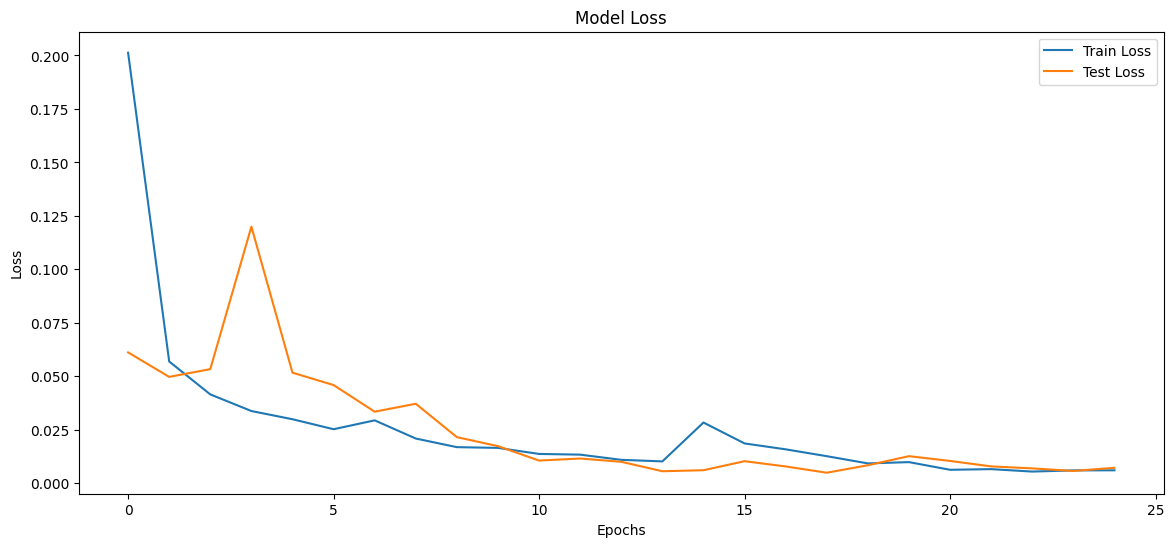

In [150]:
# Plotting training loss
plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

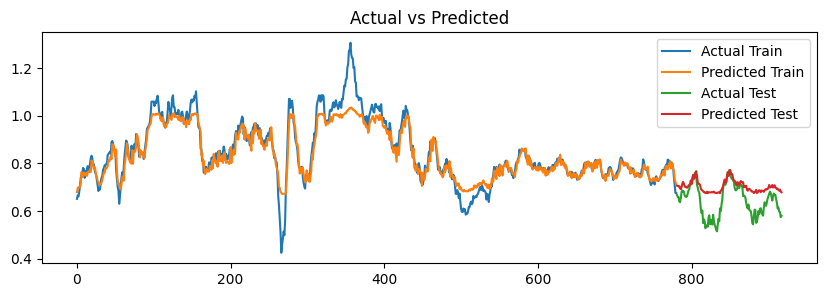

In [151]:
# Plotting actual vs predicted data
plt.figure(figsize=(10,3))

# Train data
plt.plot(train_Y_inv[:, -1], label='Actual Train')
plt.plot(train_pred_inv[:, -1], label='Predicted Train')

# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test')

plt.legend()
plt.title("Actual vs Predicted")
plt.show()

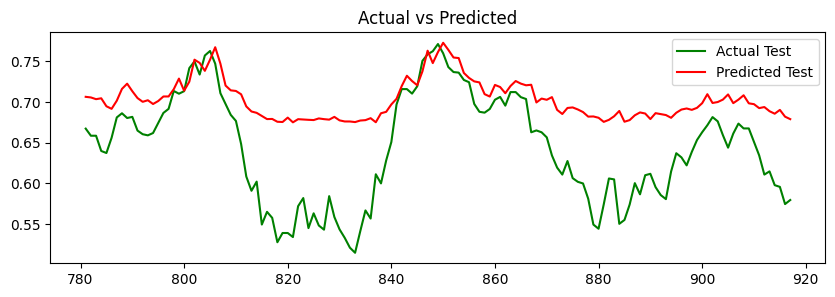

In [152]:
# Plotting actual vs predicted data
plt.figure(figsize=(10,3))

# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test', c='g')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test', c='r')

plt.legend()
plt.title("Actual vs Predicted")
plt.show()

In [162]:

look_back=10

# Define function to create time series dataset with additional features
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back+1):
        X.append(data[i:(i+look_back), :])
        Y.append(data[i+look_back:, -1]) # Utilization is the last column
    return np.array(X), np.array(Y)

# Split the dataset
train_size = int(len(data_scaled) * 0.85)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:]
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], look_back, train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], look_back, test_X.shape[2]))

# Define the Transformer Architecture
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    attn_output = MultiHeadAttention(num_heads=8, key_dim=input_shape[1])(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    attn_output2 = MultiHeadAttention(num_heads=16, key_dim=input_shape[1])(out1, out1)
    attn_output2 = Dropout(0.4)(attn_output2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn_output2)

    attn_output3 = MultiHeadAttention(num_heads=8, key_dim=input_shape[1])(out2, out2)
    attn_output3 = Dropout(0.2)(attn_output2)
    out3 = LayerNormalization(epsilon=1e-6)(out2 + attn_output3)

    ffn_output = Dense(input_shape[1], activation='relu')(out1)
    ffn_output = Dense(input_shape[1])(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out4 = LayerNormalization(epsilon=1e-6)(out3 + ffn_output)

    outputs = Dense(1)(out4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model

model = create_transformer_model((look_back, train_X.shape[2]))
model.summary()
history = model.fit(tf.convert_to_tensor(train_X), tf.convert_to_tensor(train_Y), epochs=25, batch_size=1, verbose=2, validation_data=(tf.convert_to_tensor(test_X), tf.convert_to_tensor(test_Y)))

# Make predictions
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Invert predictions
train_pred_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, train_X.shape[2])[:, :-1], train_pred.reshape(-1, 1))))
test_pred_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, test_X.shape[2])[:, :-1], test_pred.reshape(-1, 1))))
train_Y_inv = scaler.inverse_transform(np.hstack((train_X[:, -1, :-1], train_Y[:, np.newaxis])))
test_Y_inv = scaler.inverse_transform(np.hstack((test_X[:, -1, :-1], test_Y[:, np.newaxis])))


# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(train_Y_inv[:, -1], train_pred_inv[:, -1]))
test_score = np.sqrt(mean_squared_error(test_Y_inv[:, -1], test_pred_inv[:, -1]))
print('------ Train Score: {:.2f} RMSE ------'.format(train_score))
print('------ Test Score: {:.2f} RMSE ------'.format(test_score))

<ipython-input-162-2bc2f878f327>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(Y)


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 multi_head_attention_76 (Multi  (None, 10, 3)       363         ['input_2[0][0]',                
 HeadAttention)                                                   'input_2[0][0]']                
                                                                                                  
 dropout_119 (Dropout)          (None, 10, 3)        0           ['multi_head_attention_76[0][0]']
                                                                                                  
 tf_op_layer_add_4 (TensorFlowO  [(None, 10, 3)]     0           ['input_2[0][0]',         

TypeError: ignored